In [1]:
import os
from skimage.io import imread, imsave
import numpy as np
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from skimage.transform import warp
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
from numpy.polynomial import Polynomial
import pandas as pd

In [34]:
def map_func(p, edt, rs):
    rstep = np.mean(np.diff(rs))
    npos = p.shape[0]
    for i in range(npos):
        r,t = p[i,:].astype(int)
        # transformation from distance from the center
        p[i,0] = (edt[t,:,:].max() - rs[r]) / rstep
    return p

In [49]:
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
#path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'

#scope_name = 'Ti scope'
path_scope = os.path.join(path_ext, scope_name)
#df_date = '2023-12-04'
path = os.path.join(path_scope, exp_date)
#vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'

channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
# for file name
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}

exp_sum = pd.read_excel('../Notebooks/Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
positions = pd.read_excel('../Notebooks/Positions.xlsx')

In [54]:
vector = 'pLPT20&41'
pos = 19
scope_name = 'Tweez scope'
exp_date = '2023_12_08'

In [123]:
#rfp_chn = 0
yfp_chn = 0
cfp_chn = 1
ph_chn = 2
fluo_chns = 3

In [124]:
fname = f'{exp_date}_10x_1.0x_{vector}_{scopes[scope_name]}_Pos{pos}.ome.tif'
path_im = os.path.join(path, fname)
path_results = os.path.join(path, folder_results, f"pos{pos}")
fname

'2023_12_08_10x_1.0x_pLPT20&41_TiTweez_Pos19.ome.tif'

In [125]:
im_all = imread(path_im)
im_all = im_all[:,:,:,:ph_chn]
nt,nx,ny,nc = im_all.shape
print(im_all.shape)

(406, 1024, 1024, 2)


In [126]:
bg = np.zeros((nc,))
for c in range(nc):
    bg[c] = im_all[0,:100,:100,c].mean()

In [59]:
path_results = os.path.join(path, folder_results, f"pos{pos}")
edt = np.load(os.path.join(path_results,'edt.npy'))

In [127]:
edt.shape

(396, 1024, 1024)

In [63]:
edt = edt[10:,:,:]
im_all = im_all[10:,:,:,:]

In [110]:
im_all.shape

(396, 1024, 1024, 3)

#### Crop image

In [68]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
w = int(w//2) * 2
h = maxy - miny
h = int(h//2) * 2

print(w,h)
pad = 32

#crop_im_all = np.zeros((nt,w+2*pad-1,h+2*pad-1,nc))
#crop_edt = np.zeros((nt,w+2*pad-1,h+2*pad-1))
crop_im_all = np.zeros((nt-10,w+2*pad,h+2*pad,nc))
crop_edt = np.zeros((nt-10,w+2*pad,h+2*pad))
print(crop_im_all.shape)
print(crop_edt.shape)

for t in range(nt-10):
    tedt = edt[t,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    cim = im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad,:]
    crop_im_all[t,:,:,:] = cim
    crop_edt[t,:,:] = tedt[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad]

252 238
(396, 316, 302, 3)
(396, 316, 302)


In [69]:
crop_im_all.shape
mask_out = np.zeros((nt,) + (nx,ny))


(396, 316, 302, 3)

In [79]:
nt, nx, ny = crop_edt.shape

In [95]:
mask_out = np.zeros((nt,) + (nx,ny))

In [99]:
mask_out[:,:,:] = crop_edt[:,:,:]>0

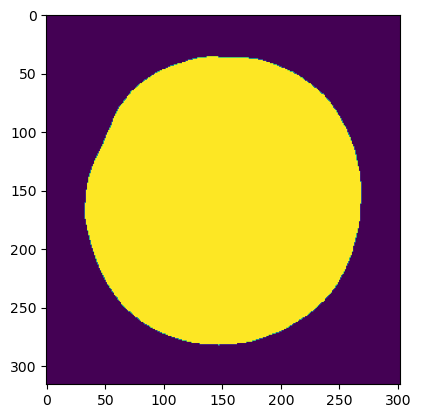

In [119]:
plt.imshow(mask_out[100,:,:])

In [120]:
mask_out[100,150,150]

1.0

In [100]:
mask_out.shape

(396, 316, 302)

In [103]:
path_results

'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Tweez scope/2023_12_08/results/pos19'

In [105]:
imsave(os.path.join(path_results, 'crop_edt.tif'), mask_out>0)


/tmp/ipykernel_3657/1198340937.py:1: UserWarning: /media/guillermo/Expansion/Thesis GY/3. Analyzed files/Tweez scope/2023_12_08/results/pos19/crop_edt.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(os.path.join(path_results, 'crop_edt.tif'), mask_out>0)


In [116]:
#np.save(os.path.join(path_results,'crop_im_all.tif'), crop_im_all)
imsave(os.path.join(path_results,'crop_im_all.tif'), crop_im_all)
#np.save(os.path.join(path_results,'crop_edt.npy'), crop_edt)

In [114]:
crop_im_all.shape

(396, 316, 302, 3)

In [113]:
crop_im_all[:,:,:,:2].shape

(396, 316, 302, 2)

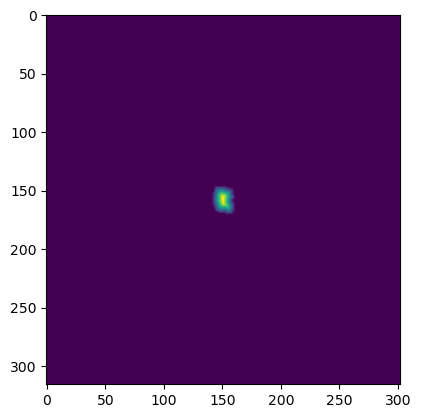

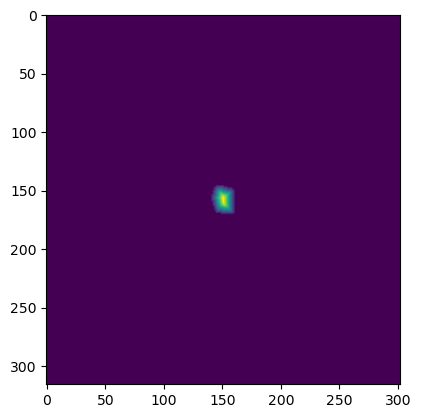

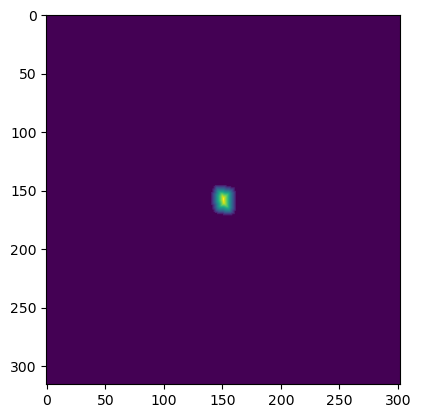

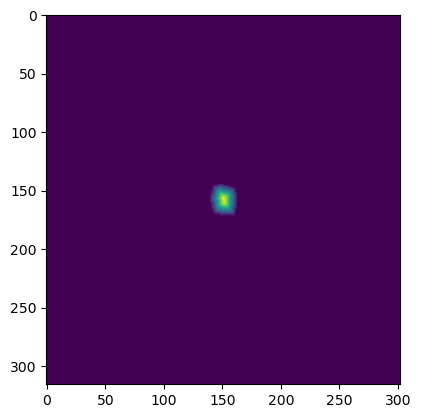

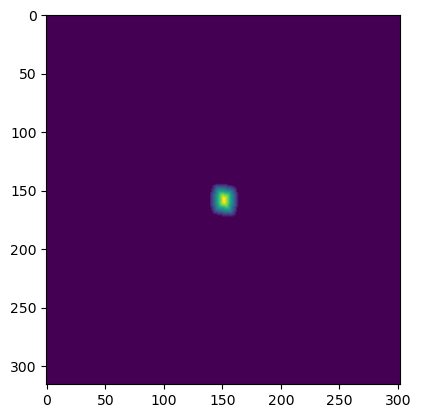

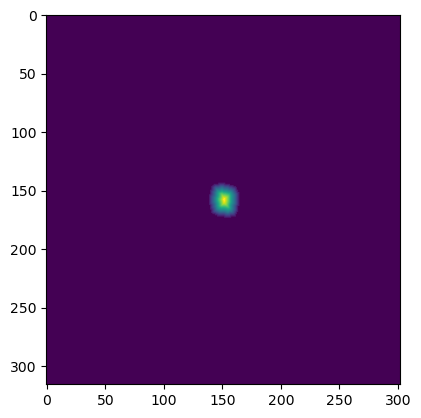

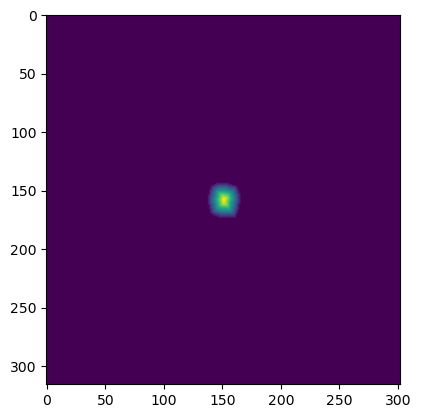

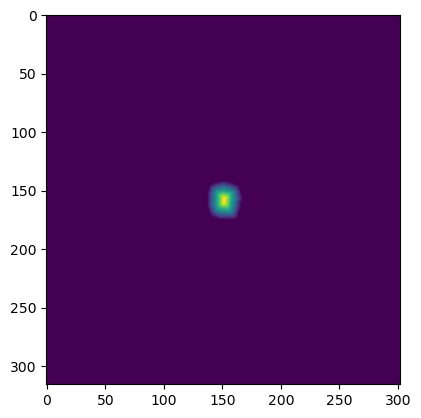

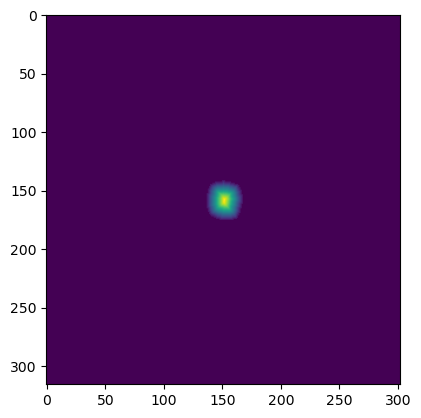

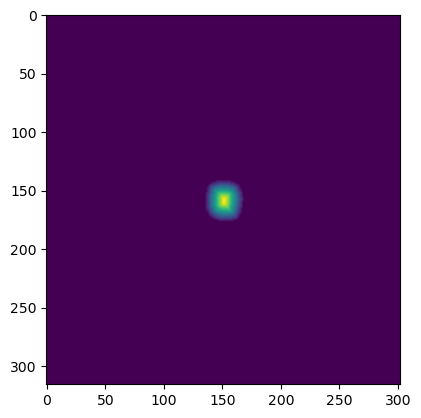

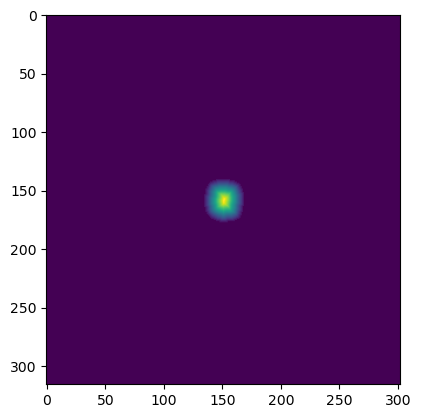

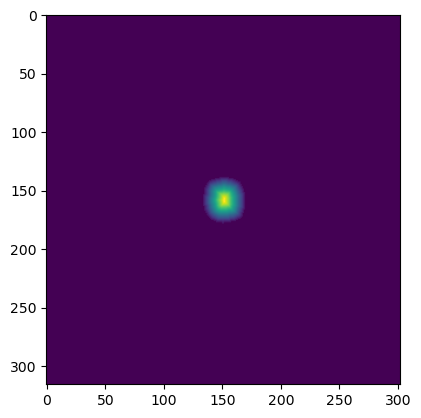

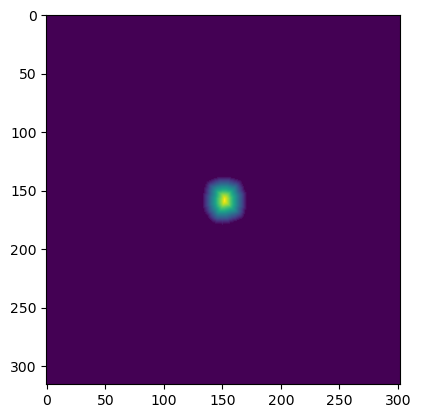

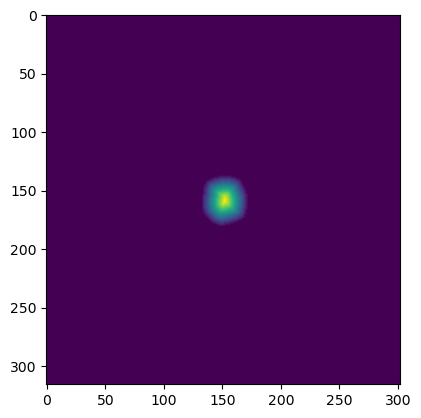

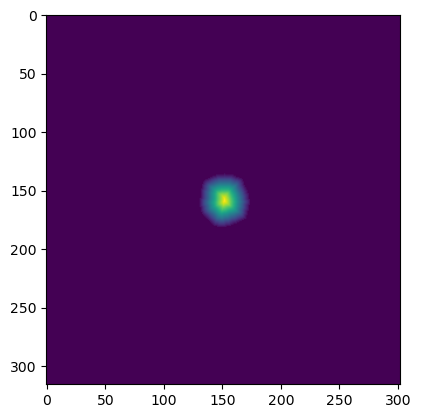

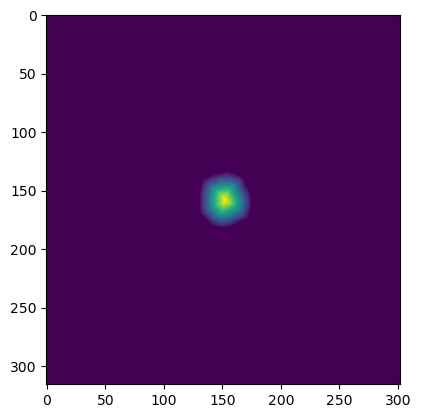

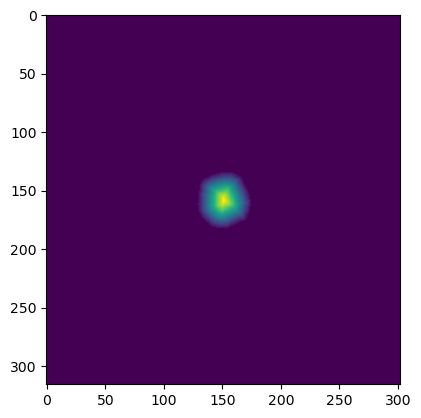

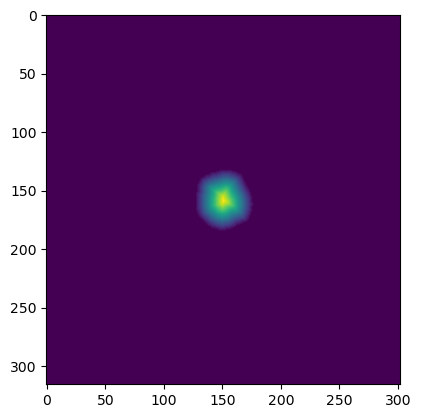

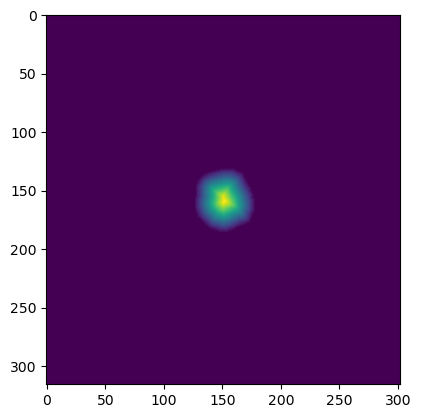

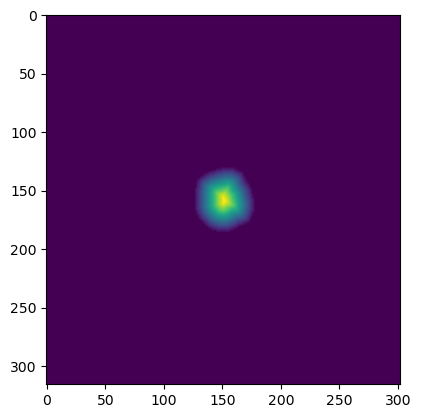

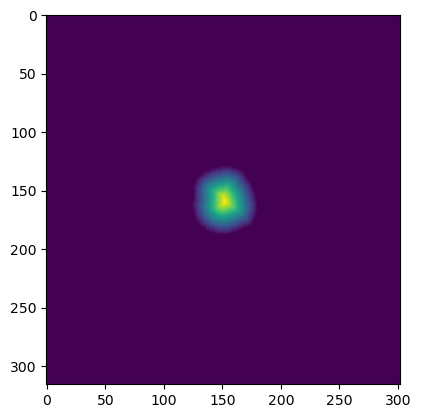

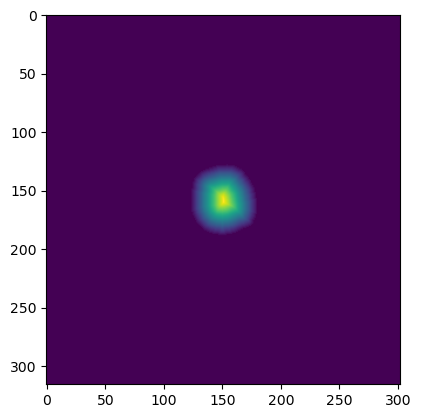

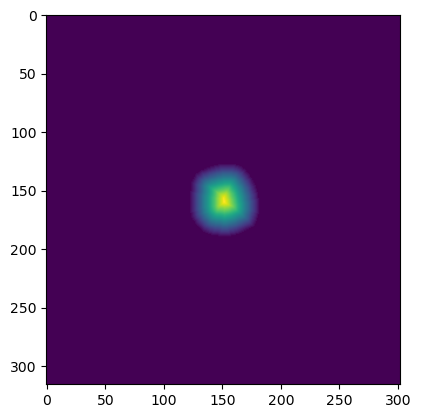

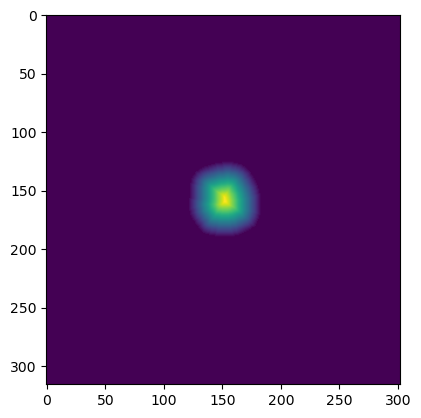

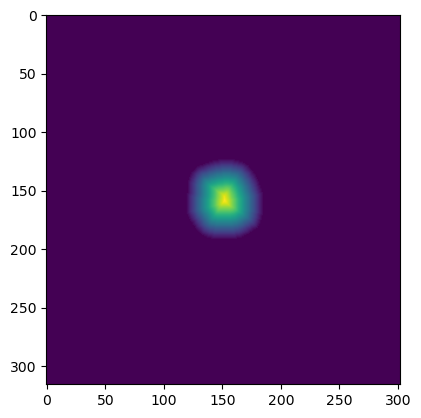

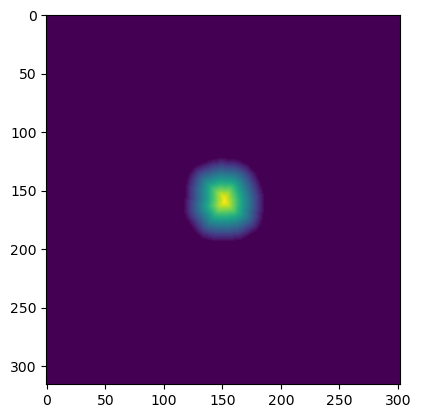

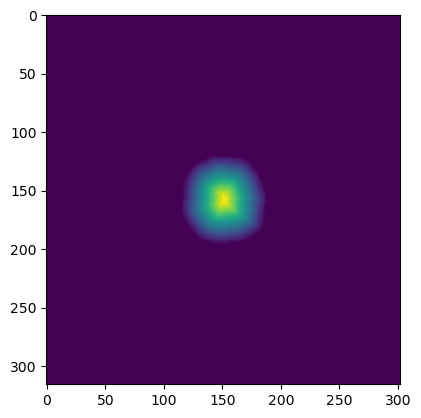

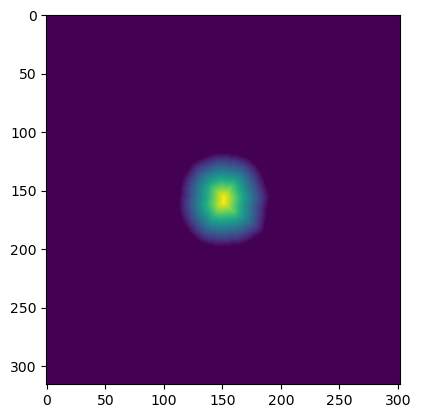

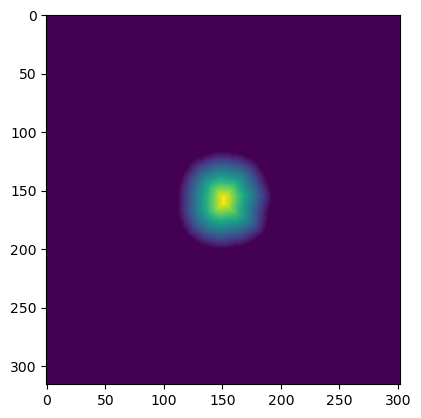

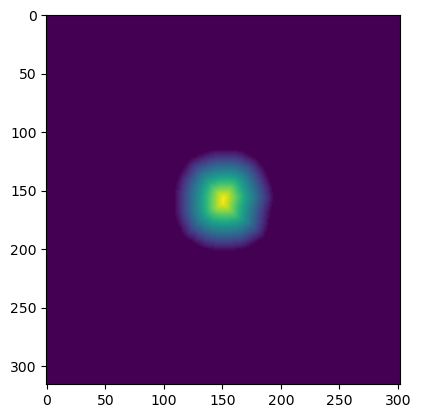

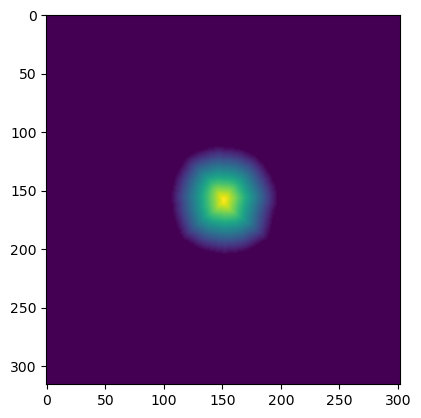

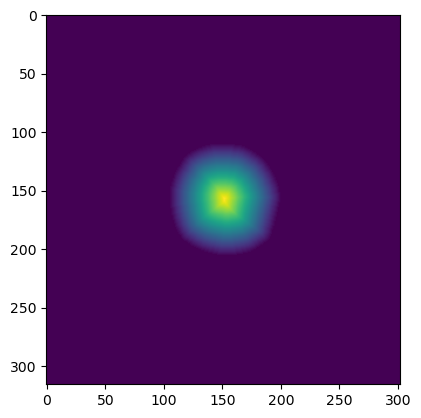

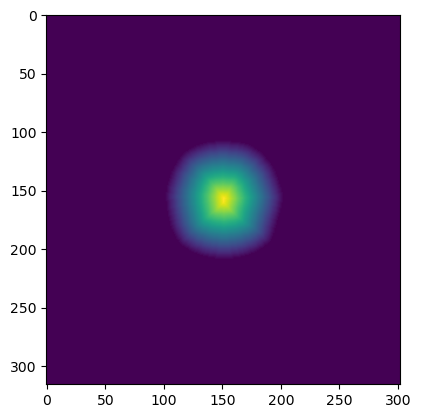

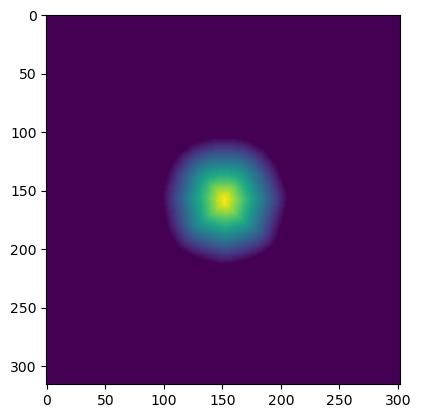

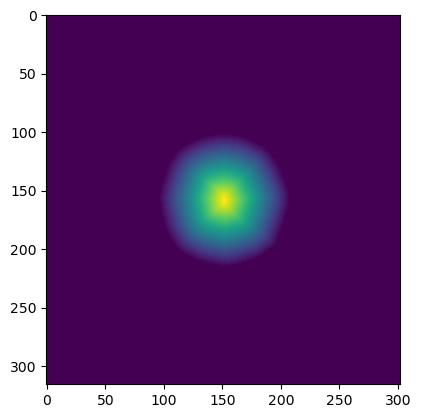

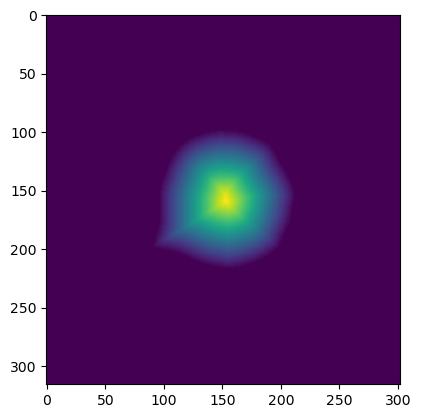

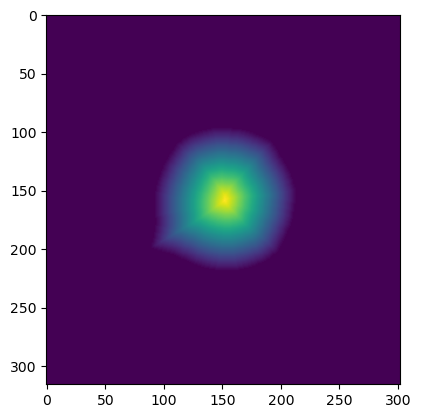

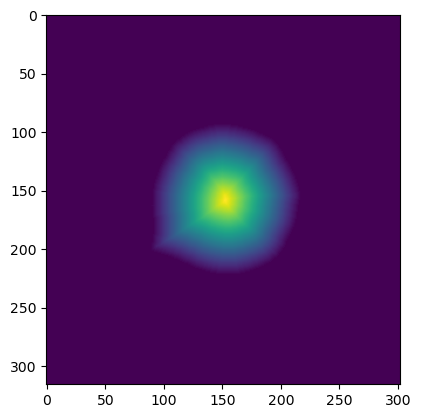

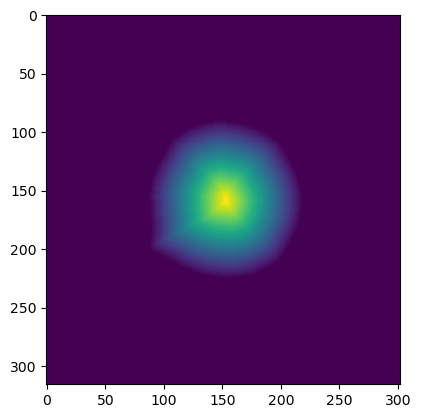

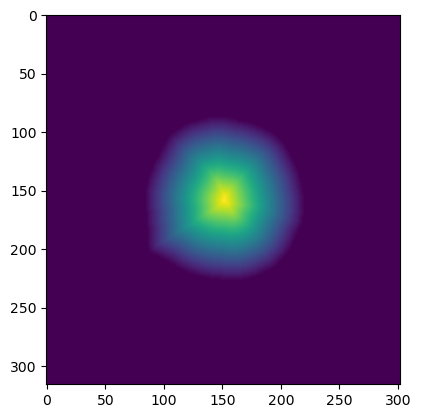

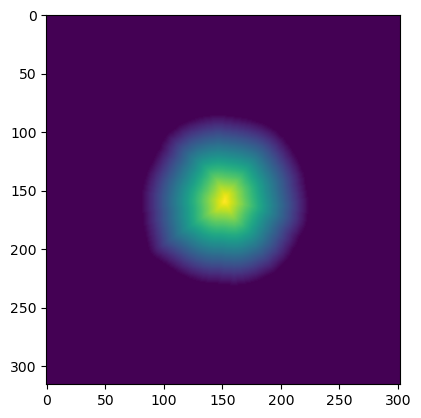

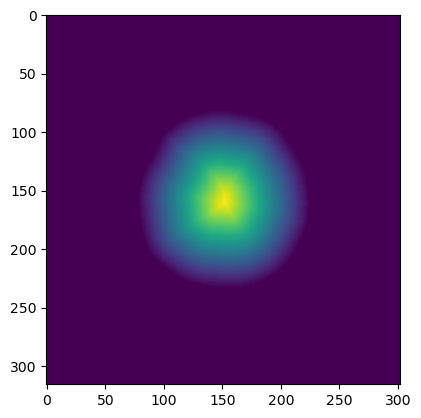

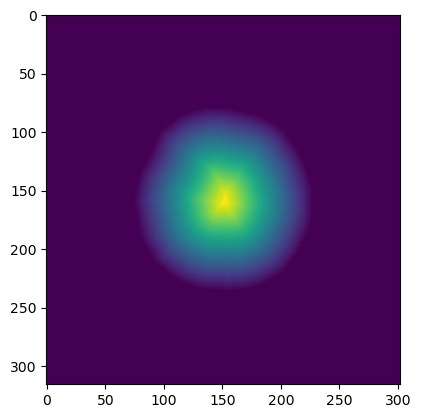

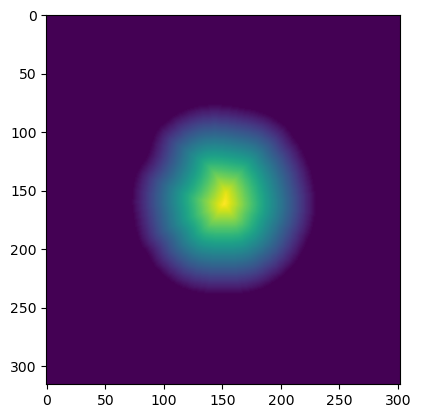

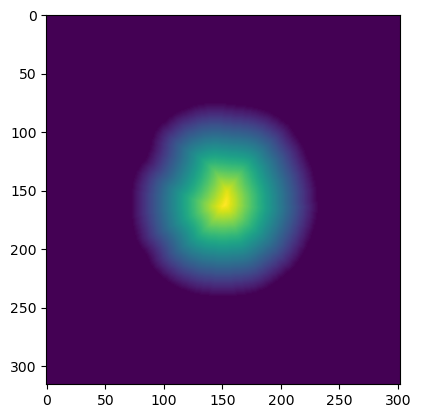

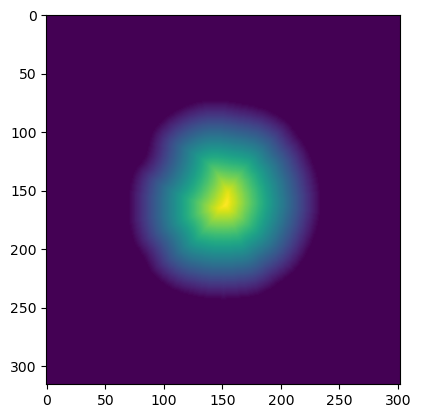

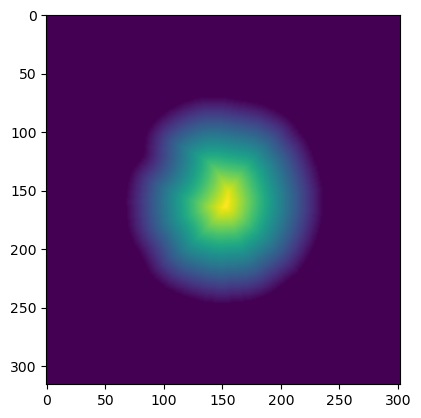

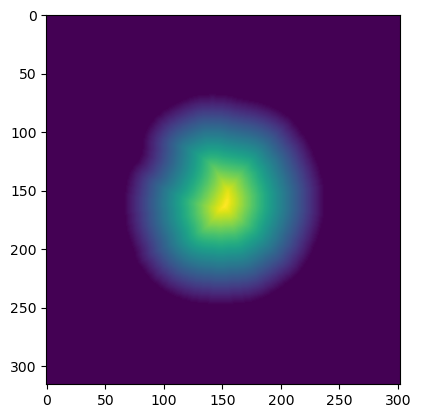

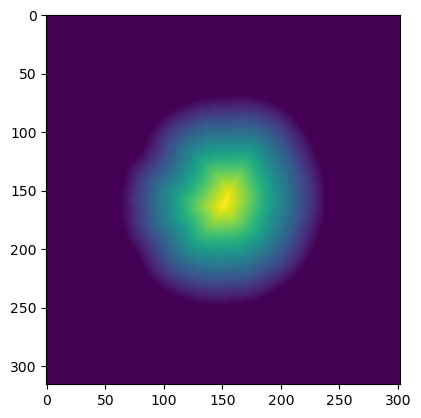

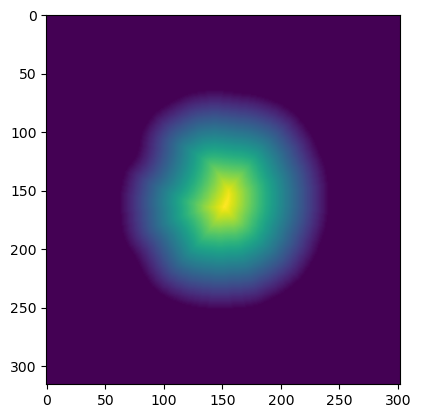

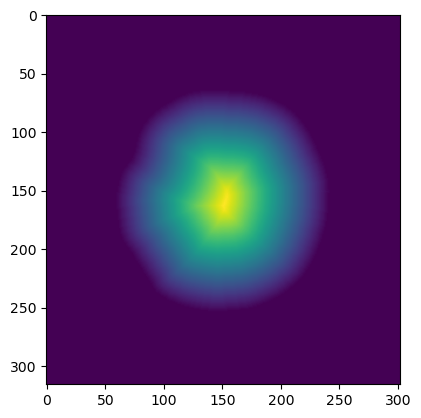

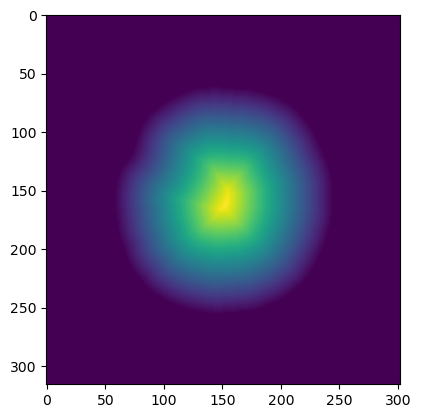

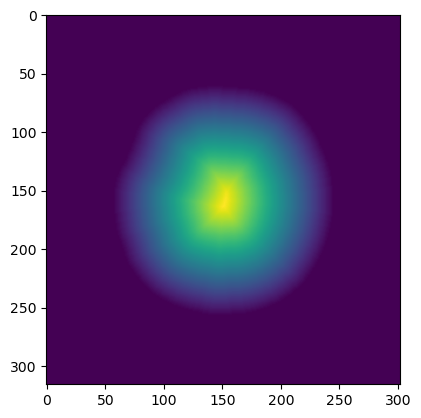

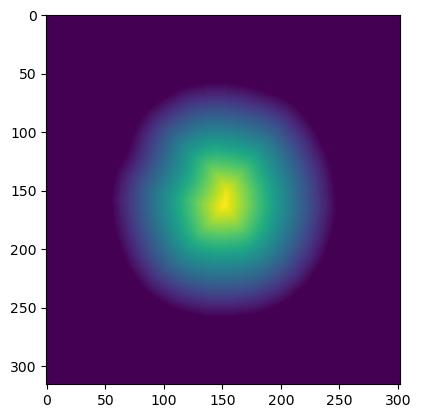

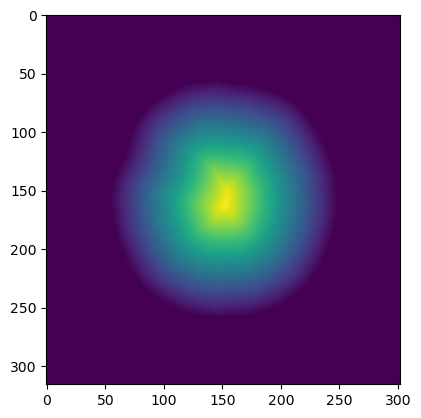

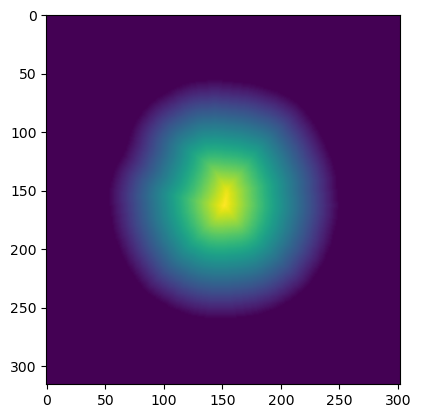

KeyboardInterrupt: 

In [76]:
for i in range(len(crop_edt)):
    plt.imshow(crop_edt[i,:,:])
    plt.show()

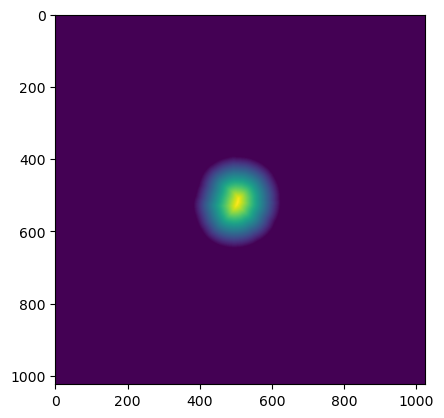

In [62]:
plt.imshow(edt0)

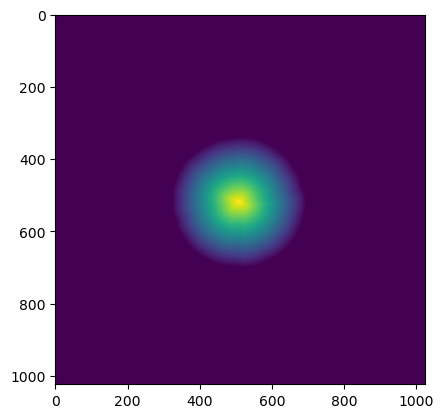

In [31]:
plt.imshow(edt[215,:,:])

In [33]:
nr = 64
rw = 8
rs = np.linspace(rw, edt.max(), nr)

cov = np.zeros((nt,nr,3,3))
corr = np.zeros((nt,nr,3))
mean = np.zeros((nt,nr,3))
for t in range(nt):
    for ri in range(nr):
        tedt = edt[t,:,:]
        idx = np.abs(tedt - rs[ri]) < rw
        if np.sum(idx)>0:
            #plt.figure()
            ntim0 = im_all[t,:,:,0].astype(float) - bg[0]
            ntim1 = im_all[t,:,:,1].astype(float) - bg[1]
            ntim2 = im_all[t,:,:,2].astype(float) - bg[2]
            x,y,z = ntim0[idx], ntim1[idx], ntim2[idx]
            C = np.cov(np.stack([x, y, z]))
            cov[t,ri,:,:] = C
            corr[t,ri,0] = np.corrcoef(x, y)[0,1]
            corr[t,ri,1] = np.corrcoef(x, z)[0,1]
            corr[t,ri,2] = np.corrcoef(y, z)[0,1]
            mean[t,ri,0] = x.mean()
            mean[t,ri,1] = y.mean()
            mean[t,ri,2] = z.mean()

/tmp/ipykernel_3657/968236376.py:18: RuntimeWarning: Degrees of freedom <= 0 for slice
  C = np.cov(np.stack([x, y, z]))
/home/guillermo/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/guillermo/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/guillermo/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


#### Map func

In [38]:
wcorr = np.zeros_like(corr)
for c in range(nc):
    wcorr[:,:,c] = warp(corr[:,:,c], map_func, {'edt':edt, 'rs':rs})
wcorr[np.isnan(corr)] = np.nan

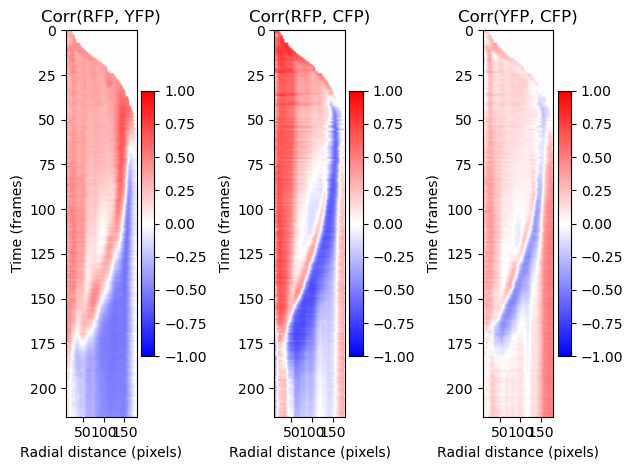

In [39]:
## the edge of the plot is the center, it needs to be mapped
## apply the warping (map function), apply the transformation

t0 = 0

plt.subplot(1,3,1)
plt.imshow(wcorr[t0:,:,0], extent=[rw,edt.max(),nt,0], aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Corr(RFP, YFP)')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(wcorr[t0:,:,1], extent=[rw,edt.max(),nt,0], aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Corr(RFP, CFP)')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(wcorr[t0:,:,2], extent=[rw,edt.max(),nt,0], aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Corr(YFP, CFP)')
plt.colorbar()

plt.tight_layout()

In [40]:
wmean = np.zeros_like(mean)
for c in range(nc):
    wmean[:,:,c] = warp(mean[:,:,c], map_func, {'edt':edt, 'rs':rs})
wmean[np.isnan(mean)] = np.nan

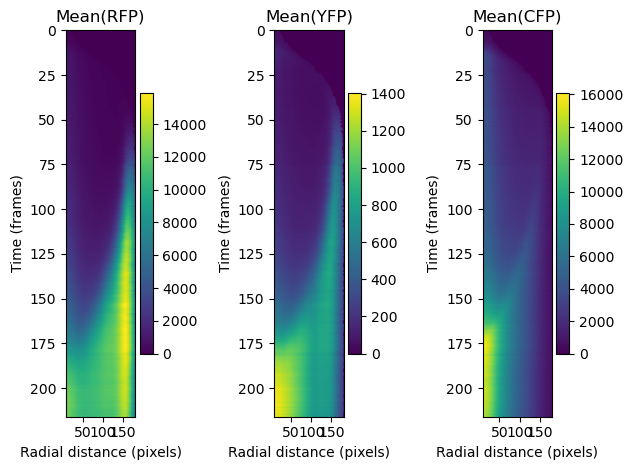

In [42]:
t0 = 0

plt.subplot(1,3,1)
plt.imshow(wmean[t0:,:,0], extent=[rw,edt.max(),nt,0], aspect='auto')
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Mean(RFP)')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(wmean[t0:,:,1], extent=[rw,edt.max(),nt,0], aspect='auto')
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Mean(YFP)')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(wmean[t0:,:,2], extent=[rw,edt.max(),nt,0], aspect='auto')
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Mean(CFP)')
plt.colorbar()

plt.tight_layout()

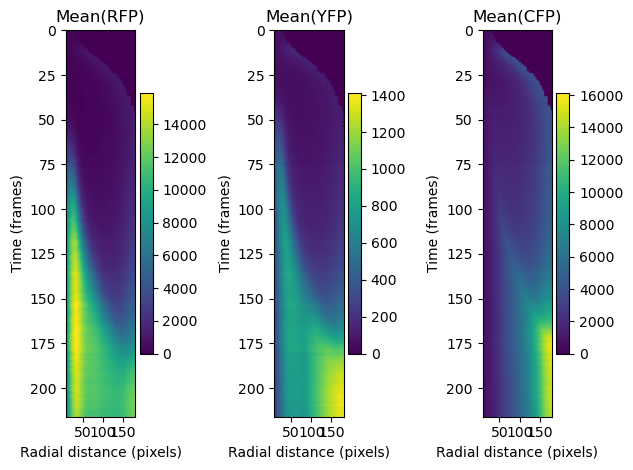

In [41]:
t0 = 0

plt.subplot(1,3,1)
plt.imshow(mean[t0:,:,0], extent=[rw,edt.max(),nt,0], aspect='auto')
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Mean(RFP)')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(mean[t0:,:,1], extent=[rw,edt.max(),nt,0], aspect='auto')
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Mean(YFP)')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(mean[t0:,:,2], extent=[rw,edt.max(),nt,0], aspect='auto')
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Mean(CFP)')
plt.colorbar()

plt.tight_layout()

In [121]:
path_im

'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Tweez scope/2023_12_08/2023_12_08_10x_1.0x_pLPT20&41_TiTweez_Pos19.ome.tif'

In [136]:
im_all.shape

(26, 1024, 1024, 2)

In [133]:
im_all = im_all[284:310,:,:,:]

In [157]:
edt = edt[284:310, :, :]

In [158]:
# Example dimensions, replace with actual data dimensions
nt, nx, ny, nc = im_all.shape  # nt: time, nx: width, ny: height, nc: channels
nr = 64
rw = 16
n_theta = 60
delta_theta = 2 * np.pi / n_theta

# Radial distances
rs = np.linspace(rw, edt.max(), nr)
thetas = np.linspace(0, 2 * np.pi, n_theta, endpoint=False)

# Initialize kymo arrays for 2 channels
kymo = np.zeros((nt, nr, n_theta, nc)) + np.nan

# Calculate kymograph
for t in range(nt):
    print(t)
    for c in range(nc):
        #print(c)
        for ri in range(nr):
            #print(ri)
            for ti, theta in enumerate(thetas):
                #print(ti)
                tedt = edt[t, :, :]
                r_mask = np.abs(tedt - rs[ri]) < rw
                y, x = np.ogrid[:ny, :nx]
                cx, cy = nx // 2, ny // 2
                theta_mask = np.arctan2(y - cy, x - cx)
                theta_mask = np.mod(theta_mask, 2 * np.pi)
                theta_band_mask = (theta_mask >= theta) & (theta_mask < theta + delta_theta)
                combined_mask = r_mask & theta_band_mask

                if np.sum(combined_mask) > 0:
                    ntcim = im_all[t, :, :, c]
                    kymo[t, ri, ti, c] = np.nanmean(ntcim[combined_mask])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [144]:
wkymo = np.zeros_like(kymo)
for c in range(nc):
    wkymo[:,:,c] = warp(kymo[:,:,c], map_func, {'edt':edt, 'rs':rs})
wkymo[np.isnan(kymo)] = np.nan

In [143]:
nc

2

In [159]:
kymo.shape

(26, 64, 60, 2)

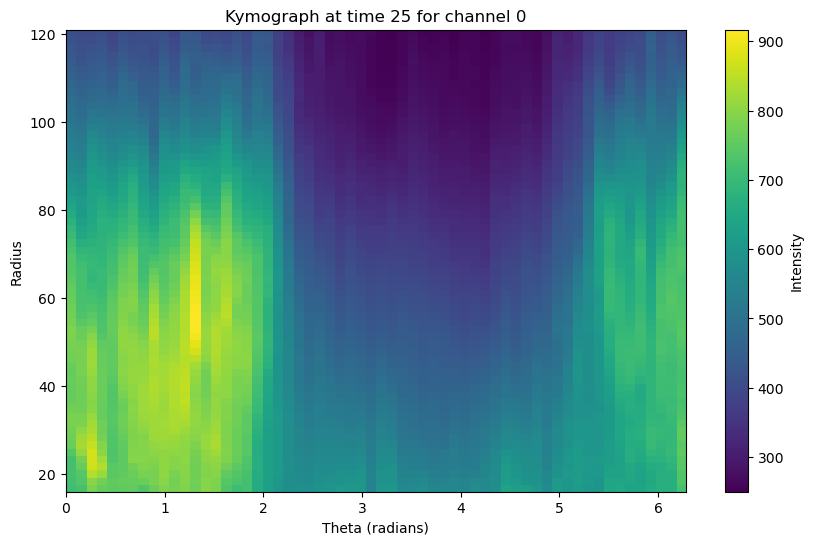

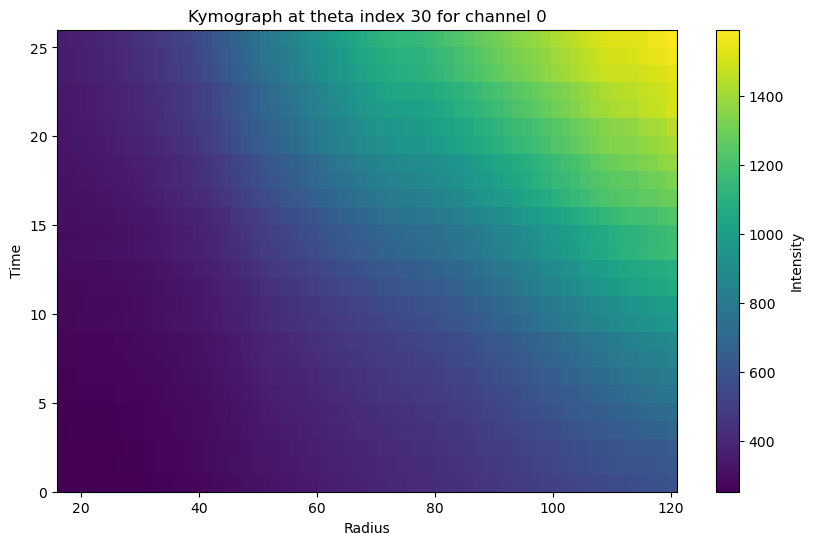

In [160]:
# Plot kymo radius vs theta for a specific time point and channel
time_point = 25
channel = 0

plt.figure(figsize=(10, 6))
plt.imshow(kymo[time_point, :, :, channel], aspect='auto', extent=[0, 2 * np.pi, rw, edt.max()], cmap='viridis')
plt.colorbar(label='Intensity')
plt.xlabel('Theta (radians)')
plt.ylabel('Radius')
plt.title(f'Kymograph at time {time_point} for channel {channel}')
plt.show()

# Plotting with the time dimension (example for radius vs. time at a specific theta)
theta_index = 30  # example index

plt.figure(figsize=(10, 6))
plt.imshow(kymo[:, :, theta_index, channel], aspect='auto', extent=[rw, edt.max(), 0, nt], cmap='viridis')
plt.colorbar(label='Intensity')
plt.xlabel('Radius')
plt.ylabel('Time')
plt.title(f'Kymograph at theta index {theta_index} for channel {channel}')
plt.show()


In [155]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numba import njit, prange

@njit(parallel=True)
def compute_kymo(nt, nx, ny, nc, nr, n_theta, rs, delta_theta, rw, edt, im_all):
    kymo = np.zeros((nt, nr, n_theta, nc)) + np.nan

    for t in prange(nt):
        print(t)
        for c in range(nc):
            for ri in range(nr):
                for ti in range(n_theta):
                    theta_min = ti * delta_theta
                    theta_max = (ti + 1) * delta_theta

                    tedt = edt[t, :, :]
                    idx_r = np.abs(tedt - rs[ri]) < rw

                    y, x = np.ogrid[:ny, :nx]
                    cx, cy = nx // 2, ny // 2
                    angles = np.arctan2(y - cy, x - cx) % (2 * np.pi)
                    idx_theta = (angles >= theta_min) & (angles < theta_max)

                    idx = idx_r & idx_theta

                    if np.sum(idx) > 0:
                        ntcim = im_all[t, :, :, c]
                        kymo[t, ri, ti, c] = np.nanmean(ntcim[idx])

    return kymo




In [156]:
# Parameters
nt, nx, ny, nc = im_all.shape
nr = 64
rw = 16
n_theta = 36
delta_theta = 2 * np.pi / n_theta

# Radial steps
rs = np.linspace(rw, edt.max(), nr)

# Compute kymo with numba
kymo = compute_kymo(nt, nx, ny, nc, nr, n_theta, rs, delta_theta, rw, edt, im_all)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Use of unsupported NumPy function 'numpy.ogrid' or unsupported use of the function.

File "../../../../../tmp/ipykernel_3657/1606195644.py", line 21:
<source missing, REPL/exec in use?>

During: typing of get attribute at /tmp/ipykernel_3657/1606195644.py (21)

File "../../../../../tmp/ipykernel_3657/1606195644.py", line 21:
<source missing, REPL/exec in use?>


In [ ]:
# Plot kymo radius vs theta for a specific time point and channel
time_point = 0
theta_index = 30  # Example theta index
channel = 0  # Example channel

plt.figure(figsize=(10, 6))
plt.imshow(kymo[:, :, theta_index, channel], aspect='auto', origin='lower', extent=[rs[0], rs[-1], 0, nt])
plt.colorbar(label='Intensity')
plt.xlabel('Radius')
plt.ylabel('Time')
plt.title(f'Kymograph at theta index {theta_index} for channel {channel}')
plt.show()